In [1]:
!pip install pandas tensorflow scikit-learn nltk textblob


In [2]:

import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import nltk
from textblob import TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer
import pickle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout


nltk.download('vader_lexicon')

# Load the dataset
data=pd.read_csv('preprocessed_combined_clean_datasetfinal.csv')
print(data)

# Drop missing values
data.dropna(inplace=True)


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


                                                     text sentiment  \
0                                              respond go   neutral   
1                                      SAD miss San Diego  negative   
2                                              boss bully  negative   
3                                         interview leave  negative   
4                                         son release buy  negative   
...                                                   ...       ...   
247080  wish we could come see you on denser husband l...  negative   
247081  I have wondered about rake to The client has m...  negative   
247082  say good for both of you Enjoy the break - you...  positive   
247083                          But it was worth it ****.  positive   
247084  All this flirting going on - The at smiles say...   neutral   

        text_length  
0              10.0  
1              18.0  
2              10.0  
3              15.0  
4              15.0  
...            

In [3]:
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import nltk
from textblob import TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer
import pickle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
import os # Import the os module
import numpy as np # Import the numpy module
# Feature engineering: Using TextBlob and Vader for polarity and sentiment analysis
data['textblob_polarity'] = data['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
sia = SentimentIntensityAnalyzer()
data['vader_sentiment'] = data['text'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Encode the sentiment labels to integers
le = LabelEncoder()
data['sentiment'] = le.fit_transform(data['sentiment'])

# Tokenize the text data
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(data['text'])
sequences = tokenizer.texts_to_sequences(data['text'])
padded_sequences = pad_sequences(sequences, maxlen=100, padding='post', truncating='post')


# Load pre-trained GloVe embeddings
embedding_index = {}
embedding_dim = 100  # Using 100-dimensional GloVe embeddings
# Download GloVe embeddings if not present
glove_file = 'glove.6B.100d.txt'
if not os.path.exists(glove_file):
    print("Downloading GloVe embeddings...")
    !pip install wget # Install the wget module
    import wget
    url = 'http://nlp.stanford.edu/data/glove.6B.zip'
    wget.download(url)
    # Unzip the file
    import zipfile
    with zipfile.ZipFile('glove.6B.zip', 'r') as zip_ref:
        zip_ref.extractall('.')
# Read the embeddings
print("Loading GloVe embeddings...")
with open(glove_file, encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefficients = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefficients

# Create embedding matrix
word_index = tokenizer.word_index
num_words = min(20000, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i >= 20000:
        continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, data['sentiment'], test_size=0.2, random_state=42)



  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=c2b9d45515885b6be4a1ff6bc208dd676c7421200c48b20a10e15f4954cc36f2
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
Loading GloVe embeddings...


In [7]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization

# Define your model
# Define your model
model = Sequential([
    Embedding(input_dim=num_words, output_dim=embedding_dim, weights=[embedding_matrix], input_length=100), # Changed input_dim to num_words
    Conv1D(filters=64, kernel_size=5, activation='relu', kernel_regularizer=l2(0.01)),  # Reduced filters
    BatchNormalization(),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),  # Reduced units
    Dropout(0.6),
    Dense(len(le.classes_), activation='softmax')
])


# Compile the model with a lower learning rate
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(learning_rate=0.00001),  # Lower learning rate
              metrics=['accuracy'])

# Set up early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

from tensorflow.keras.callbacks import ReduceLROnPlateau  # Import ReduceLROnPlateau
# Define the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)


# Train the model
history = model.fit(X_train, y_train,
          epochs=40,
          validation_data=(X_test, y_test),
          callbacks=[lr_scheduler])  # Added Early Stopping

# Save the model
model.save('cnn_model.h5')

# Generate predictions on the validation or test set
cnn_predictions = model.predict(X_test)
cnn_predictions = np.argmax(cnn_predictions, axis=1)  # Assuming a classification problem

# Save predictions to CSV
pd.DataFrame({'prediction': cnn_predictions, 'true_label': y_test}).to_csv('cnn_predictions.csv',index=False)


# Save the tokenizer and label encoder (unchanged)
with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('label_encoder.pkl', 'wb') as handle:
    pickle.dump(le, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("Model, tokenizer, and label encoder saved successfully!")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/40
6178/6178 ━━━━━━━━━━━━━━━━━━━━ 52s 8ms/step - accuracy: 0.3423 - loss: 5.5120 - val_accuracy: 0.4063 - val_loss: 2.4255 - learning_rate: 1.0000e-05
Epoch 2/40
6178/6178 ━━━━━━━━━━━━━━━━━━━━ 70s 6ms/step - accuracy: 0.3876 - loss: 2.4148 - val_accuracy: 0.4415 - val_loss: 2.1884 - learning_rate: 1.0000e-05
Epoch 3/40
6178/6178 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - accuracy: 0.4219 - loss: 2.1445 - val_accuracy: 0.5032 - val_loss: 1.9311 - learning_rate: 1.0000e-05
Epoch 4/40
6178/6178 ━━━━━━━━━━━━━━━━━━━━ 53s 7ms/step - accuracy: 0.4699 - loss: 1.9095 - val_accuracy: 0.5403 - val_loss: 1.7339 - learning_rate: 1.0000e-05
Epoch 5/40
6178/6178 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - accuracy: 0.5074 - loss: 1.7332 - val_accuracy: 0.5726 - val_loss: 1.5799 - learning_rate: 1.0000e-05
Epoch 6/40
6178/6178 ━━━━━━━━━━━━━━━━━━━━ 44s 6ms/step - accuracy: 0.5400 - loss: 1.5944 - val_accuracy: 0.5984 - val_loss: 1.4591 - learning_rate: 1.0000e-05
Epoch 7/40
6178/6178 ━━━━━━━━━━━━━━━━━━━━ 36s 

1545/1545 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
Model, tokenizer, and label encoder saved successfully!


In [25]:
from sklearn.metrics import classification_report, accuracy_score

# Calculate accuracy
accuracy = accuracy_score(y_test, cnn_predictions)
print(f"Accuracy: {accuracy:.4f}")

# Generate a detailed classification report (includes Precision, Recall, and F1-Score)
report = classification_report(y_test, cnn_predictions, target_names=le.classes_)
print("Classification Report:\n")
print(report)


Accuracy: 0.7739
Classification Report:

              precision    recall  f1-score   support

    negative       0.80      0.72      0.76     13810
     neutral       0.72      0.80      0.76     20021
    positive       0.83      0.79      0.81     15586

    accuracy                           0.77     49417
   macro avg       0.78      0.77      0.77     49417
weighted avg       0.78      0.77      0.77     49417



Accuracy: 0.7739


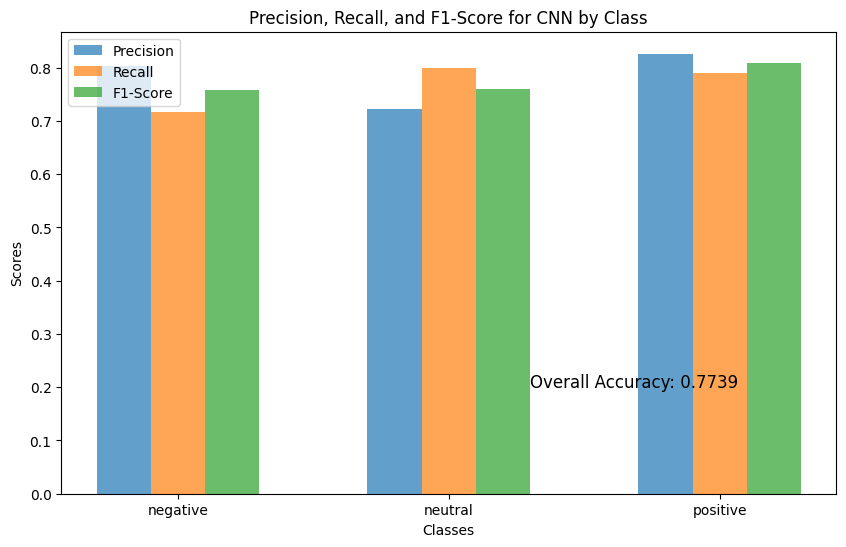

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score

# Calculate accuracy
accuracy = accuracy_score(y_test, cnn_predictions)
print(f"Accuracy: {accuracy:.4f}")

# Generate classification report as a dictionary
report = classification_report(y_test, cnn_predictions, target_names=le.classes_, output_dict=True)

# Extract Precision, Recall, F1-Score values for each class
precision = [report[cls]['precision'] for cls in le.classes_]
recall = [report[cls]['recall'] for cls in le.classes_]
f1_score = [report[cls]['f1-score'] for cls in le.classes_]

# Class labels
classes = le.classes_

# Set width of bars
bar_width = 0.2
index = np.arange(len(classes))

# Plot Precision, Recall, and F1-Score for each class
plt.figure(figsize=(10, 6))

# Plotting precision, recall, and f1-score
plt.bar(index, precision, bar_width, label='Precision', alpha=0.7)
plt.bar(index + bar_width, recall, bar_width, label='Recall', alpha=0.7)
plt.bar(index + 2 * bar_width, f1_score, bar_width, label='F1-Score', alpha=0.7)

# Set the x ticks and labels
plt.xlabel('Classes')
plt.ylabel('Scores')
plt.title('Precision, Recall, and F1-Score for CNN by Class')
plt.xticks(index + bar_width, classes)

# Add accuracy as text
plt.text(len(classes) - 1.5, 0.2, f'Overall Accuracy: {accuracy:.4f}', fontsize=12, color='black')

# Add legend
plt.legend()

# Display the plot
plt.show()


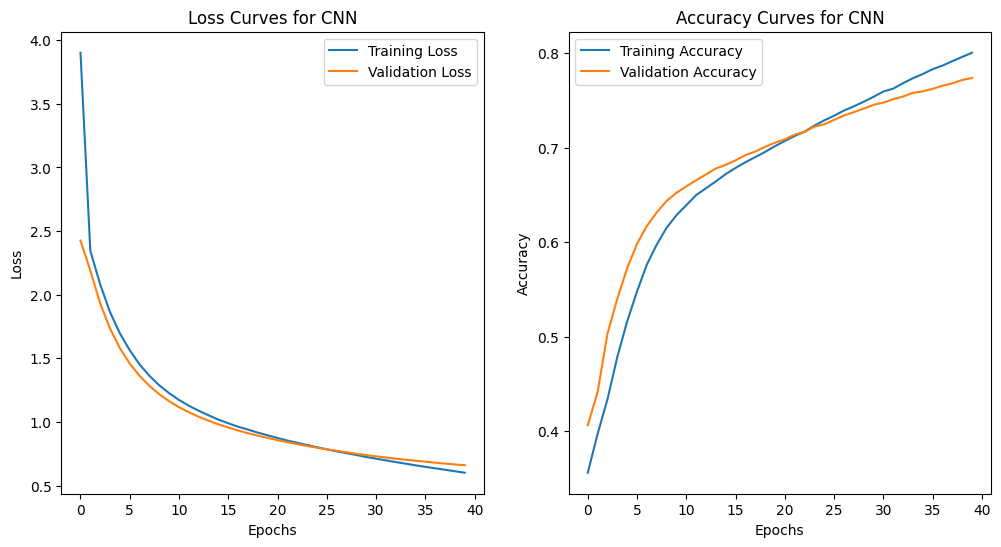

In [16]:
import matplotlib.pyplot as plt

# Plot Training and Validation Loss/Accuracy Curves
def plot_training_curves(history):
    # Loss Curves
    plt.figure(figsize=[12, 6])
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss Curves for CNN')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    # Accuracy Curves
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy Curves for CNN')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

plot_training_curves(history)


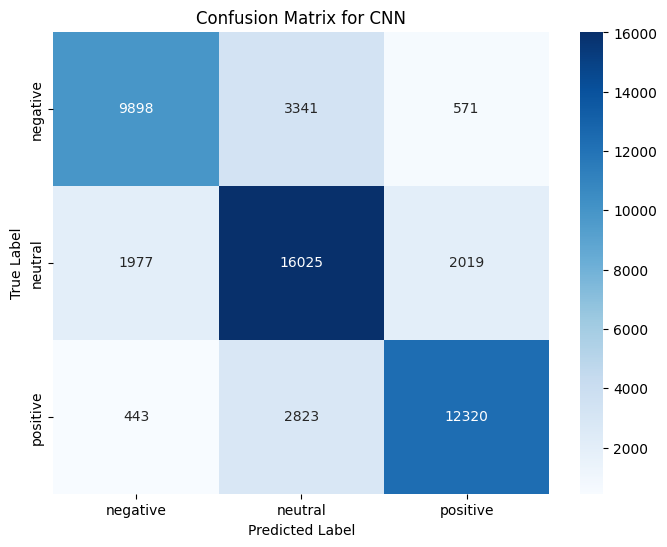

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Confusion Matrix
cm = confusion_matrix(y_test, cnn_predictions)

# Plot Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix for CNN')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


1545/1545 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


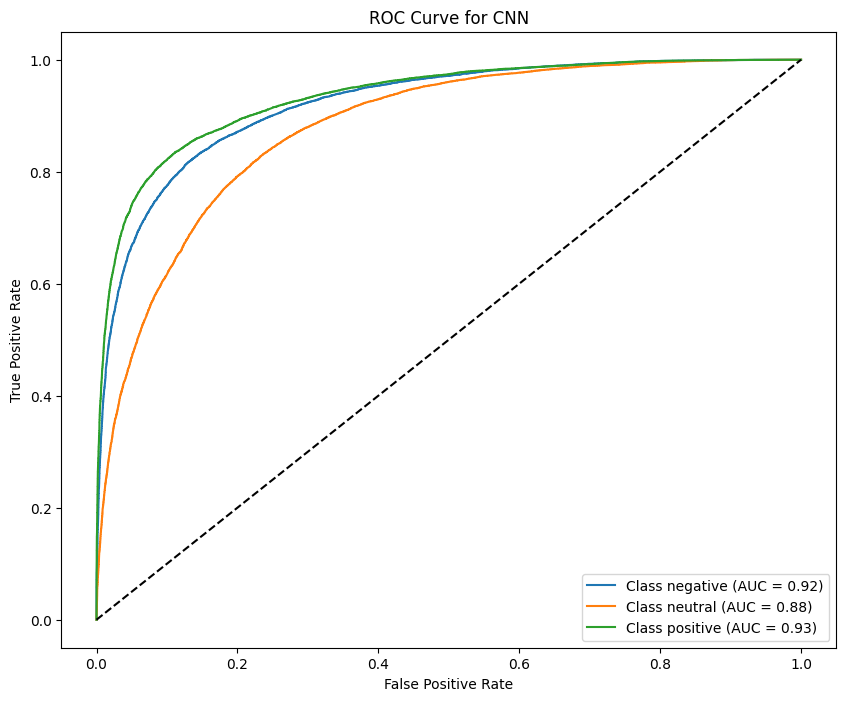

Overall AUC: 0.91


In [19]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Binarize the labels for multi-class ROC
y_test_bin = label_binarize(y_test, classes=range(len(le.classes_)))

# Get predicted probabilities instead of class labels
cnn_probabilities = model.predict(X_test)  # Get predicted probabilities

# Calculate ROC curves for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(le.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], cnn_probabilities[:, i]) # Use probabilities for each class
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(len(le.classes_)):
    plt.plot(fpr[i], tpr[i], label=f"Class {le.classes_[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.title('ROC Curve for CNN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# Calculate overall AUC using probabilities
overall_auc = roc_auc_score(y_test_bin, cnn_probabilities, average='macro') # Use probabilities
print(f"Overall AUC: {overall_auc:.2f}")

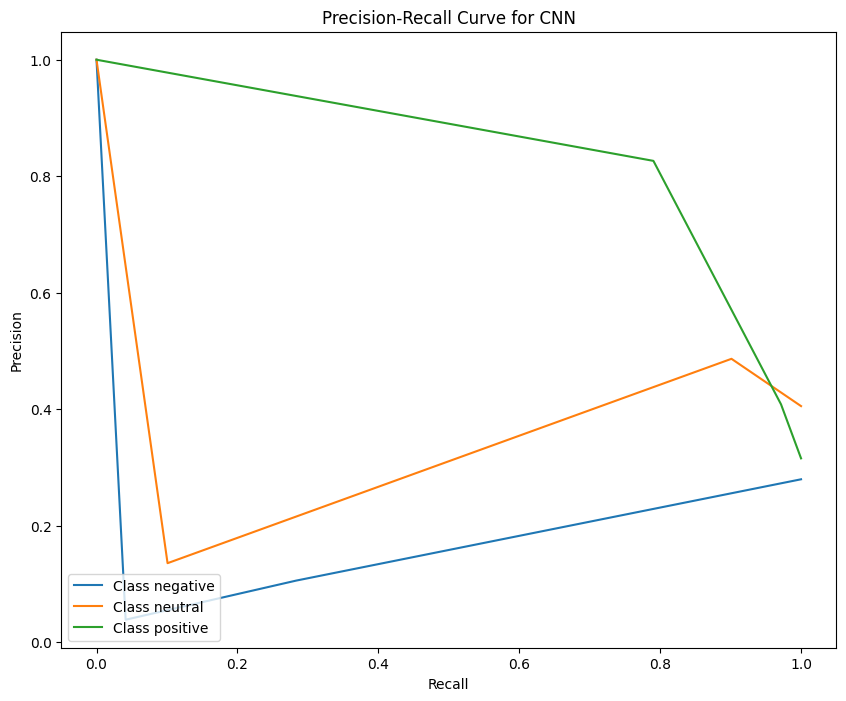

In [20]:
from sklearn.metrics import precision_recall_curve

# Plot Precision-Recall Curve for each class
plt.figure(figsize=(10, 8))
for i in range(len(le.classes_)):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], cnn_predictions)
    plt.plot(recall, precision, label=f"Class {le.classes_[i]}")

plt.title('Precision-Recall Curve for CNN')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.show()


1545/1545 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


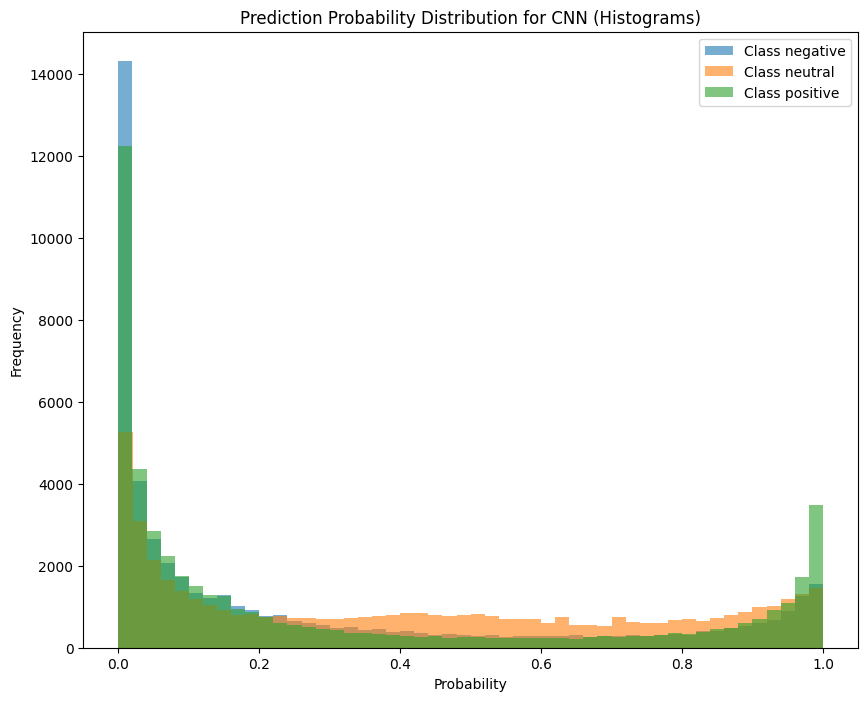

In [21]:
# Prediction probabilities (before taking argmax)
cnn_probabilities = model.predict(X_test)

# Plot histograms of prediction probabilities for each class
plt.figure(figsize=(10, 8))
for i in range(len(le.classes_)):
    plt.hist(cnn_probabilities[:, i], bins=50, alpha=0.6, label=f"Class {le.classes_[i]}")

plt.title('Prediction Probability Distribution for CNN (Histograms)')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()


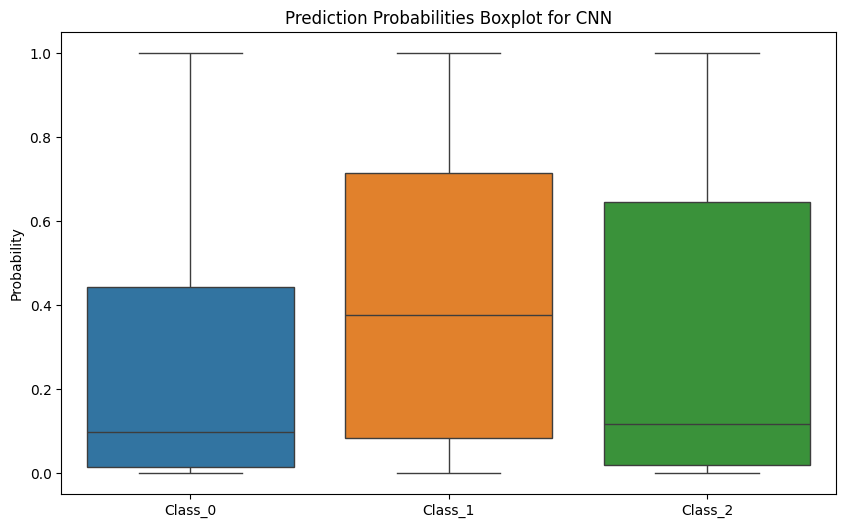

In [22]:
import seaborn as sns
import pandas as pd

# Convert probabilities to a DataFrame for visualization
df_probabilities = pd.DataFrame(cnn_probabilities, columns=[f"Class_{i}" for i in range(len(le.classes_))])

# Create box plots
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_probabilities)
plt.title('Prediction Probabilities Boxplot for CNN')
plt.ylabel('Probability')
plt.show()
